Exploring the output files generated by the Salish Sea Atlantis Model
for the BC Parks Living Labs Project - preliminary runs

Scenarios
- control
- heatwave (2023 summer for 10 days)
- RCP8.5

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups

## scenario files

In [22]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/control_01/outputSalishSea.nc"
heatwave_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/heatwave_01/outputSalishSea.nc"
climate_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/climate_01/outputSalishSea.nc"
# scenario3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/heatwave3/outputSalishSea.nc"

control = xr.open_dataset(str(control_file), decode_cf=True)
heatwave = xr.open_dataset(str(heatwave_file), decode_cf=True)
climate = xr.open_dataset(str(climate_file), decode_cf=True)
# scenario3 = xr.open_dataset(str(scenario3_file), decode_cf=True)

t = np.ma.filled(control.variables['t'], np.nan)

In [12]:
# t_corrected = t - np.timedelta64(578, 'D')

start = 0 #after burn-in. Model start 2007 (112 if model start is 1992)
end = 50 #t.size-1

time = t[start:end]

## Group plotting functions

In [19]:

# Plot variables
label_size = 11
font_size = 12
line_width = 2

def plot_benthic(group, scenario): # benthos, shellfish

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim(y_min,  y_max)

    for species in group:
        benthic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:], np.nan) # tonnes
        benthic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:], np.nan)
        ratio = benthic_oiled.sum(axis=1) / benthic_control.sum(axis=1) 
        control_ratio = benthic_control.sum(axis=1)  / benthic_control.sum(axis=1) 
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group) #, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_pelagic(group, scenario): #bacteria, plankton

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([0.99, 1.01])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,0:5], np.nan) # tonnes, take only water column layers
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled.sum(axis=1) / p_control.sum(axis=1) 
        control_ratio = p_control.sum(axis=1) / p_control.sum(axis=1)
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_bacteria(scenario):

    bacteria = groups.bacteria

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in bacteria:
        if "pelagic" in species:
            bact_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,:,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,:,0:5,], np.nan)
            b_oiled = bact_oiled.sum(axis=2)
            b_control = bact_control.sum(axis=2)
        else:
            b_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,:,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,:,6], np.nan)
        
        ratio = b_oiled.sum(axis=1) / b_control.sum(axis=1) 
        control_ratio = b_control.sum(axis=1) / b_control.sum(axis=1)
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_sediment(group, scenario): #mostly for sediment_feeders

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        sed_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,6], np.nan) # tonnes
        sed_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,6], np.nan)
        s_oiled = sed_oiled.sum(axis=1)
        s_control = sed_control.sum(axis=1)
        ratio = s_oiled / s_control
        control_ratio = s_control / s_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)


In [20]:
def plot_cohorts(group, scenario):

    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(3,1, figsize = (14,9), sharex='all')
    ax[0].set_title('Numbers - all cohorts', fontsize = font_size)
    ax[0].set_ylabel('scenario : control')
    ax[0].tick_params(labelsize=label_size)
    ax[0].set_ylim([y_min, y_max])

    ax[1].set_title('Structural Nitrogen (bone size) - all cohorts', fontsize = font_size)
    ax[1].set_ylabel('scenario : control')
    ax[1].tick_params(labelsize=label_size)
    ax[1].set_ylim([y_min, y_max])

    ax[2].set_title('Reserve Nitrogen (fatty tissue) - all cohorts', fontsize = font_size)
    ax[2].set_ylabel('scenario : control')
    ax[2].tick_params(labelsize=label_size)
    ax[2].set_ylim([y_min, y_max])

    for species in group:

        numCohorts = groups.cohorts[group[species]]

        o1_numbers = np.ma.zeros((scenario.variables[group[species] + '1_Nums'].shape),dtype = np.int32)
        o1_structuralN = np.ma.zeros((scenario.variables[group[species] + '1_StructN'].shape),dtype = np.int32)
        o1_reservedN = np.ma.zeros((scenario.variables[group[species] + '1_ResN'].shape),dtype = np.int32)

        c1_numbers = np.ma.zeros((control.variables[group[species] + '1_Nums'].shape),dtype = np.int32)
        c1_structuralN = np.ma.zeros((control.variables[group[species] + '1_StructN'].shape),dtype = np.int32)
        c1_reservedN = np.ma.zeros((control.variables[group[species] + '1_ResN'].shape),dtype = np.int32)    

        for cohort in range (1, numCohorts+1):

            new_species = group[species] + str(cohort)
        
            o1_numbers = o1_numbers + np.ma.filled(scenario.variables[new_species + '_Nums'][:,:,:], np.nan)
            o1_structuralN = o1_structuralN + np.ma.filled(scenario.variables[new_species +'_StructN'][:,:,:], np.nan)
            o1_reservedN = o1_reservedN + np.ma.filled(scenario.variables[new_species +'_ResN'][:,:,:], np.nan)

            c1_numbers = c1_numbers + np.ma.filled(control.variables[new_species + '_Nums'][:,:,:], np.nan)
            c1_structuralN = c1_structuralN + np.ma.filled(control.variables[new_species +'_StructN'][:,:,:], np.nan)
            c1_reservedN = c1_reservedN + np.ma.filled(control.variables[new_species +'_ResN'][:,:,:], np.nan)

        o2_numbers = o1_numbers.sum(axis=2)
        o2_structuralN = o1_structuralN.sum(axis=2)
        o2_reservedN = o1_reservedN.sum(axis=2)

        c2_numbers = c1_numbers.sum(axis=2)
        c2_structuralN = c1_structuralN.sum(axis=2)
        c2_reservedN = c1_reservedN.sum(axis=2)

        numbers = o2_numbers.sum(axis=1) / c2_numbers.sum(axis=1)
        structuralN = o2_structuralN.sum(axis=1) / c2_structuralN.sum(axis=1)
        reservedN = o2_reservedN.sum(axis=1) / c2_reservedN.sum(axis=1)
    
        ax[0].plot(time, numbers[start:end], linewidth = line_width)
        ax[0].legend(group, loc='center left')
   
        ax[1].plot(time, structuralN[start:end],linewidth = line_width)

        ax[2].plot(time, reservedN[start:end],linewidth = line_width)
    

In [21]:
def plot_benthic_box(group, scenario, box_number): # benthos, shellfish

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim(y_min, y_max)

    for species in group:
        benthic_oiled = scenario.variables[group[species] + '_N'][start:end,box_number] # tonnes
        benthic_control = control.variables[group[species] + '_N'][start:end,box_number]
        ratio = benthic_oiled / benthic_control
        control_ratio = benthic_control / benthic_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_bacteria_box(scenario, box_number): #bacteria, plankton

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in groups.bacteria:
        if "pelagic" in species:
            bact_oiled = np.ma.filled(scenario.variables[groups.bacteria[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[groups.bacteria[species] + '_N'][start:end,box_number,0:5], np.nan)
            b_oiled = bact_oiled.sum(axis=1)
            b_control = bact_control.sum(axis=1)
        else:
            b_oiled = np.ma.filled(scenario.variables[groups.bacteria[species] + '_N'][start:end,box_number,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[groups.bacteria[species] + '_N'][start:end,box_number,6], np.nan)
        
        ratio = b_oiled / b_control
        control_ratio = b_control / b_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(groups.bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_pelagic_box(group, scenario, box_number): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
    #ax.set_ylim([0.99, 1.01])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled / p_control
        control_ratio = p_control / p_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_sediment_box(group, scenario, box_number): #mostly for sediment_feeders

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        s_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,6], np.nan) # tonnes
        s_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,6], np.nan)
        ratio = s_oiled / s_control
        control_ratio = s_control / s_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_pelagic_biomass_box(group, scenario, box_number):

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

def plot_benthic_biomass_box(group, scenario, box_number): 

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number], np.nan)
        p_oiled = pelagic_oiled
        p_control = pelagic_control
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

def plot_sediment_biomass_box(group, scenario, box_number): 

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,6], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,6], np.nan)
        p_oiled = pelagic_oiled
        p_control = pelagic_control
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

def plot_surface_biomass_box(group, scenario, box_number): # benthos, shellfish

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])

        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,4:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,4:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

## heatwaves

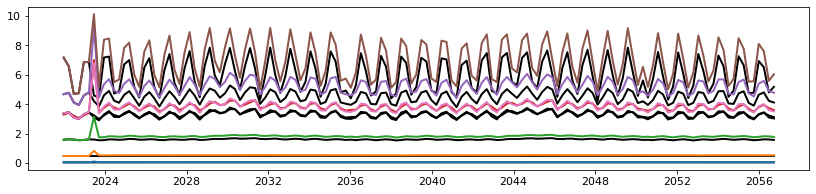

In [11]:
# Temperature at all depths - heatwave_01
fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=label_size)

Temp_control = np.ma.filled(control.Temp[start:end,:,:], np.nan)
t_control = Temp_control.mean(axis=1)
t_control = Temp_control.mean(axis=1)

Temp_heatwave = np.ma.filled(heatwave.Temp[start:end,:,:], np.nan)
t_heatwave = Temp_heatwave.mean(axis=1)
t_heatwave = Temp_heatwave.mean(axis=1)

ax.plot(time, t_control, 'k', linewidth = 2)
ax.plot(time, t_heatwave, linewidth = 2)

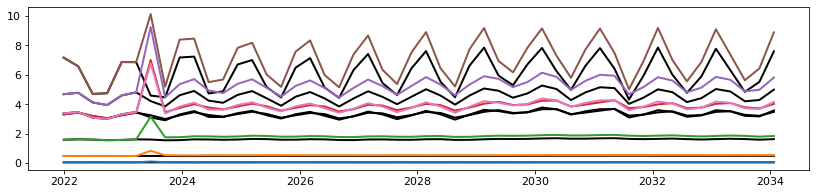

In [13]:
# Temperature at all depths - heatwave_01
fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=label_size)

Temp_control = np.ma.filled(control.Temp[start:end,:,:], np.nan)
t_control = Temp_control.mean(axis=1)
t_control = Temp_control.mean(axis=1)

Temp_heatwave = np.ma.filled(heatwave.Temp[start:end,:,:], np.nan)
t_heatwave = Temp_heatwave.mean(axis=1)
t_heatwave = Temp_heatwave.mean(axis=1)

ax.plot(time, t_control, 'k', linewidth = 2)
ax.plot(time, t_heatwave, linewidth = 2)

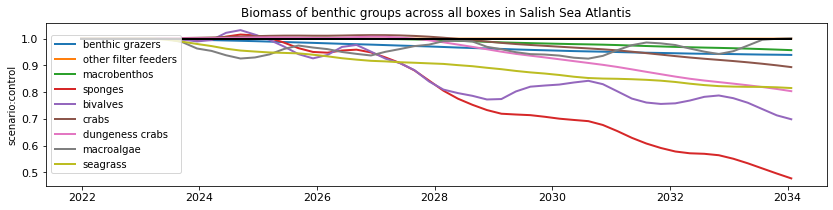

In [18]:
plot_benthic_box(groups.benthos, heatwave, 66)

## climate change

In [39]:
#If different time scale neeeded
start = 0
end = t.size-1

time = t[start:end]

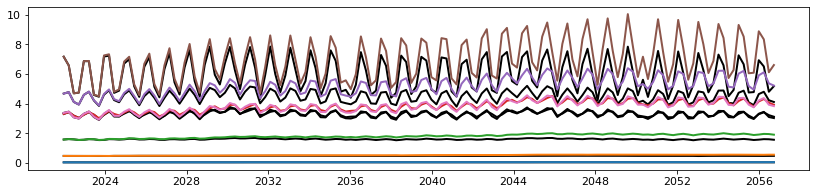

In [41]:
# Temperature at all depths - climate_01
fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=label_size)

Temp_control = np.ma.filled(control.Temp[start:end,:,:], np.nan)
t_control = Temp_control.mean(axis=1)
t_control = Temp_control.mean(axis=1)

Temp_climate = np.ma.filled(climate.Temp[start:end,:,:], np.nan)
t_climate = Temp_climate.mean(axis=1)
t_climate = Temp_climate.mean(axis=1)

ax.plot(time, t_control, 'k', linewidth = 2)
ax.plot(time, t_climate, linewidth = 2)

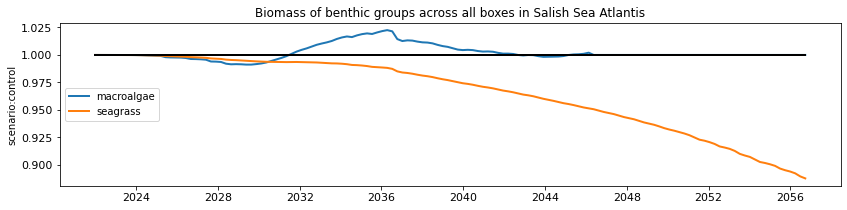

In [42]:
plot_benthic_box(groups.macroalgae, climate, 63) 

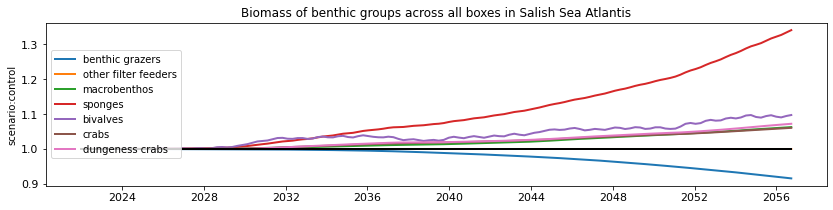

In [43]:
plot_benthic_box(groups.benthic_invertebrates, climate, 63)

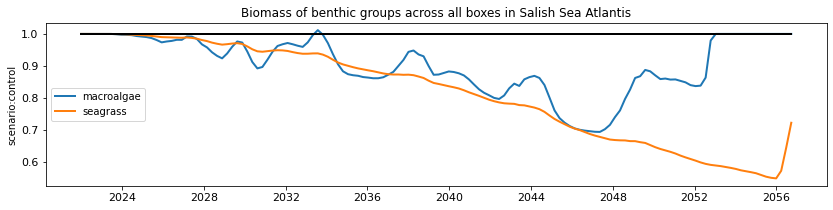

In [44]:
plot_benthic_box(groups.macroalgae, climate, 66) 

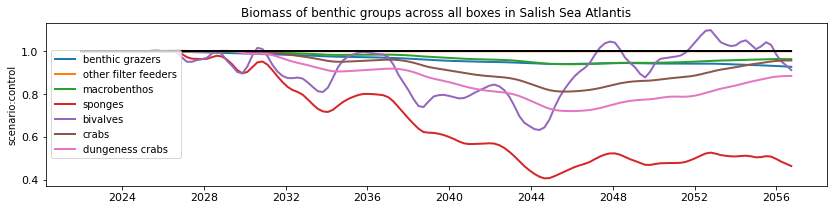

In [45]:
plot_benthic_box(groups.benthic_invertebrates, climate, 66)

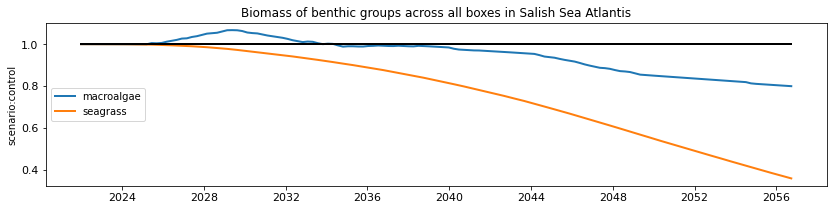

In [46]:
plot_benthic_box(groups.macroalgae, climate, 83) 

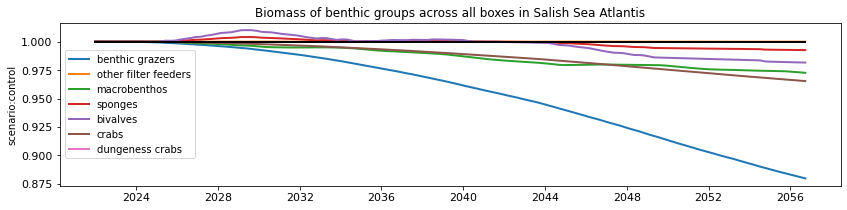

In [47]:
plot_benthic_box(groups.benthic_invertebrates, climate, 83)

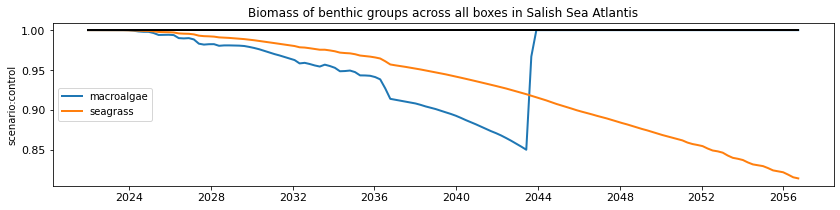

In [48]:
plot_benthic_box(groups.macroalgae, climate, 96)

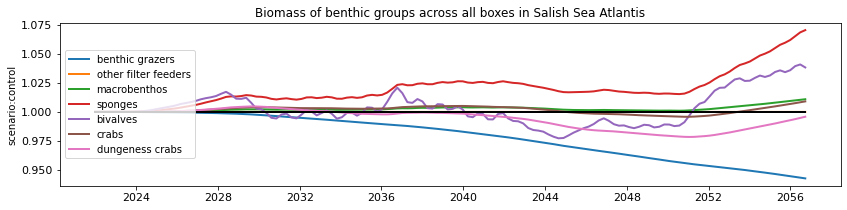

In [49]:
plot_benthic_box(groups.benthic_invertebrates, climate, 96)

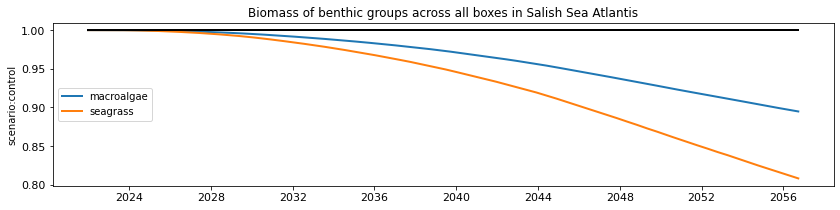

In [50]:
plot_benthic_box(groups.macroalgae, climate, 102)

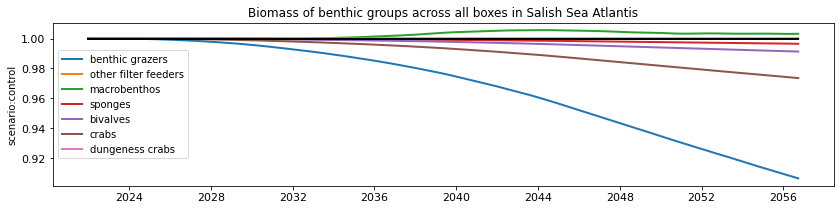

In [51]:
plot_benthic_box(groups.benthic_invertebrates, climate, 102)

In [58]:
t[128]

numpy.datetime64('2053-07-12T14:00:00.000000000')

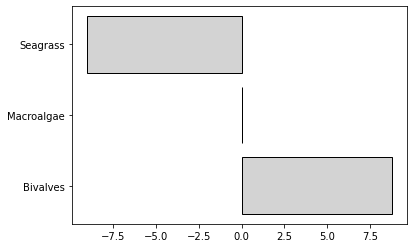

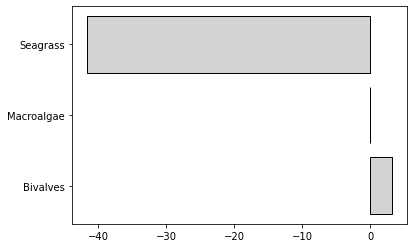

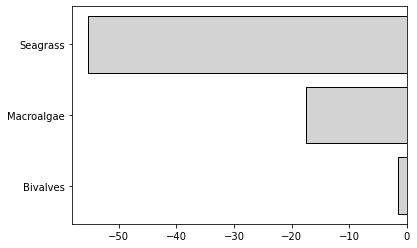

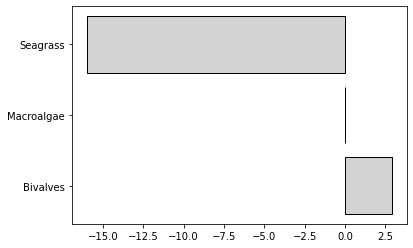

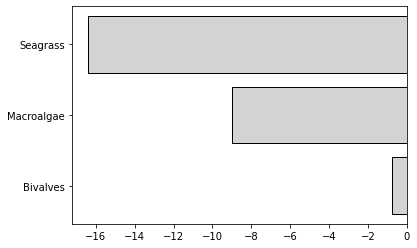

In [76]:
boxes = [63, 66, 83, 96, 102]

for box in boxes:
    macroalgae1 = np.ma.filled(climate.variables['Macroalgae_N'][128,box], np.nan)
    m_control = np.ma.filled(control.variables['Macroalgae_N'][128,box], np.nan)
    seagrass1 = np.ma.filled(climate.variables['Seagrass_N'][128,box], np.nan)
    s_control = np.ma.filled(control.variables['Seagrass_N'][128,box], np.nan)
    bivalves1 = np.ma.filled(climate.variables['Bivalves_N'][128,box], np.nan)
    b_control = np.ma.filled(control.variables['Bivalves_N'][128,box], np.nan)

    macroalgae = (macroalgae1/m_control-1)*100
    seagrass = (seagrass1/s_control-1)*100
    bivalves = (bivalves1/b_control-1)*100

    bio_groups = ['Bivalves','Macroalgae','Seagrass',]
    results = [bivalves,macroalgae,seagrass]

    ax = plt.barh(bio_groups, results, color = 'lightgrey', edgecolor= 'black')
    plt.show()
